# 3. InceptionResNetV2_SE

## Run name

In [1]:
import time

project_name = 'inclusive-images-challenge'
step_name = '3_InceptionResNetV2_SE'
time_str = time.strftime("%Y%m%d-%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

time0 = time.time()

run_name: inclusive-images-challenge_3_InceptionResNetV2_SE_20181024-143818


## Important params

In [2]:
debug_rows = None #100*10000
image_size = 200
batch_size = 128

print(debug_rows, batch_size)

None 128


## Import pkgs

In [3]:
import os
import random
import time
import re
import math
import multiprocessing
from tqdm import tqdm_notebook
from tqdm import tqdm
import imghdr
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, jaccard_similarity_score

cpu_amount = multiprocessing.cpu_count()
random_num = 0 #np.random.randint(0, 9999)
random_num_str = '%04d' % random_num

print('cpu_amount: %s' % (cpu_amount - 1))
print('random_num: %s' % random_num_str)

cpu_amount: 7
random_num: 0000


## Project folders

In [4]:
cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
log_folder = os.path.join(cwd, 'log')

cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
log_folder = os.path.join(cwd, 'log')

print(feature_folder)
print(input_folder)
print(output_folder)
print(model_folder)
print(log_folder)
train_folder = os.path.join(input_folder, 'train')
validation_folder = os.path.join(input_folder, 'validation')
test_folder = os.path.join(input_folder, 'test')
stage_1_test_images_folder = os.path.join(input_folder, 'stage_1_test_images')
sl_train_folder = os.path.join(input_folder, 'sl_train')
sl_val_folder = os.path.join(input_folder, 'sl_val')
sl_test_folder = os.path.join(input_folder, 'sl_test')

print(train_folder)
print(validation_folder)
print(test_folder)
print(stage_1_test_images_folder)
print(sl_train_folder)
print(sl_val_folder)
print(sl_test_folder)

class_descriptions_csv = os.path.join(input_folder, 'class-descriptions.csv')
class_trainable_csv = os.path.join(input_folder, 'classes-trainable.csv')
stage_1_attributions_csv = os.path.join(input_folder, 'stage_1_attributions.csv')
stage_1_sample_submission_csv = os.path.join(input_folder, 'stage_1_sample_submission.csv')
train_bounding_boxes_csv = os.path.join(input_folder, 'train_bounding_boxes.csv')
train_human_labels_csv = os.path.join(input_folder, 'train_human_labels.csv')
train_machine_labels_csv = os.path.join(input_folder, 'train_machine_labels.csv')
tuning_labels_csv = os.path.join(input_folder, 'tuning_labels.csv')

print(class_descriptions_csv)
print(class_trainable_csv)
print(stage_1_attributions_csv)
print(stage_1_sample_submission_csv)
print(train_bounding_boxes_csv)
print(train_human_labels_csv)
print(train_machine_labels_csv)
print(tuning_labels_csv)

/data/kaggle-Inclusive-Images/feature
/data/kaggle-Inclusive-Images/input
/data/kaggle-Inclusive-Images/output
/data/kaggle-Inclusive-Images/model
/data/kaggle-Inclusive-Images/log
/data/kaggle-Inclusive-Images/input/train
/data/kaggle-Inclusive-Images/input/validation
/data/kaggle-Inclusive-Images/input/test
/data/kaggle-Inclusive-Images/input/stage_1_test_images
/data/kaggle-Inclusive-Images/input/sl_train
/data/kaggle-Inclusive-Images/input/sl_val
/data/kaggle-Inclusive-Images/input/sl_test
/data/kaggle-Inclusive-Images/input/class-descriptions.csv
/data/kaggle-Inclusive-Images/input/classes-trainable.csv
/data/kaggle-Inclusive-Images/input/stage_1_attributions.csv
/data/kaggle-Inclusive-Images/input/stage_1_sample_submission.csv
/data/kaggle-Inclusive-Images/input/train_bounding_boxes.csv
/data/kaggle-Inclusive-Images/input/train_human_labels.csv
/data/kaggle-Inclusive-Images/input/train_machine_labels.csv
/data/kaggle-Inclusive-Images/input/tuning_labels.csv


## Load csv

In [5]:
%%time
# files = list(os.listdir(train_folder))
# print(len(files))
# print(files[:10])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [6]:
%%time
train_bounding_boxes_df = pd.read_csv(train_bounding_boxes_csv, nrows=debug_rows)

CPU times: user 19.2 s, sys: 1.5 s, total: 20.7 s
Wall time: 20.7 s


In [7]:
# %%time
# train_machine_labels_df = pd.read_csv(train_machine_labels_csv)

In [8]:
# %%time
# train_human_labels_df = pd.read_csv(train_human_labels_csv)

In [9]:
%%time
stage_1_attributions_df = pd.read_csv(stage_1_attributions_csv)

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 28.5 ms


In [10]:
%%time
stage_1_sample_submission_df = pd.read_csv(stage_1_sample_submission_csv)

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 27.6 ms


In [11]:
display('train_bounding_boxes_df', train_bounding_boxes_df.shape, train_bounding_boxes_df.head(2))
# display('train_machine_labels_df', train_machine_labels_df.shape, train_machine_labels_df.head(2))
# display('train_human_labels_df', train_human_labels_df.shape, train_human_labels_df.head(2))
display('stage_1_attributions_df', stage_1_attributions_df.shape, stage_1_attributions_df.head(2))
display('stage_1_sample_submission_df', stage_1_sample_submission_df.shape, stage_1_sample_submission_df.head(2))

'train_bounding_boxes_df'

(14610229, 13)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.0125,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.0250,0.276563,0.714063,0.948438,0,1,0,0,0


'stage_1_attributions_df'

(32580, 2)

,image_id,source
0,2b2b327132556c767a736b3d,Nita Ar
1,2b2b394755692f303963553d,Sathya Esarapu


'stage_1_sample_submission_df'

(32580, 2)

,image_id,labels
0,2b2b327132556c767a736b3d,/m/0sgh53y /m/0g4cd0
1,2b2b394755692f303963553d,/m/0sgh53y /m/0g4cd0


In [12]:
print(len(set(train_bounding_boxes_df['LabelName'])), '--> Use this 599 labels, approximate 600 labels')
# print(len(set(train_machine_labels_df['LabelName'])))
# print(len(set(train_human_labels_df['LabelName'])))
# print(len(set(stage_1_sample_submission_df['labels'])))

599 --> Use this 599 labels, approximate 600 labels


In [13]:
labels = list(set(train_bounding_boxes_df['LabelName']))
len_labels = len(labels)
print(len_labels)
label2num = {}
num2label = {}
for i, label in enumerate(labels):
    label2num[label] = i
    num2label[i] = label
# print(label2num)
# print(num2label)

599


## Split

In [14]:
%%time

data_ids = list(set(train_bounding_boxes_df['ImageID']))
train_ids, val_ids = train_test_split(data_ids, test_size=0.05, random_state=random_num)
print('len(data_ids):\t', len(data_ids))
print('len(train_ids):\t%s\t' % len(train_ids), len(train_ids)/len(data_ids))
print('len(val_ids):\t%s\t' % len(val_ids), len(val_ids)/len(data_ids))
train_id_set = set(train_ids)
val_id_set = set(val_ids)

train_df = train_bounding_boxes_df[train_bounding_boxes_df['ImageID'].apply(lambda x: x in train_id_set)]
val_df = train_bounding_boxes_df[train_bounding_boxes_df['ImageID'].apply(lambda x: x in val_id_set)]
print('train_df.shape:\t', train_df.shape, '\t', train_df.shape[0]/train_bounding_boxes_df.shape[0])
print('val_df.shape:\t', val_df.shape, '\t\t', val_df.shape[0]/train_bounding_boxes_df.shape[0])

len(data_ids):	 1743042
len(train_ids):	1655889	 0.9499994836613231
len(val_ids):	87153	 0.050000516338676866
train_df.shape:	 (13875206, 13) 	 0.9496912060721293
val_df.shape:	 (735023, 13) 		 0.050308793927870674
CPU times: user 8.9 s, sys: 416 ms, total: 9.31 s
Wall time: 9.3 s


## Create train validation test soft link

In [15]:
# %%time
# !rm -rf /data/kaggle-Inclusive-Images/input/sl_train
# !rm -rf /data/kaggle-Inclusive-Images/input/sl_val
# !rm -rf /data/kaggle-Inclusive-Images/input/sl_test

In [16]:
# a = b

In [17]:
# !ls /data/kaggle-Inclusive-Images/input/sl_train/ -l

In [18]:
# # Remove folder
# def remove_folder(folder):
#     if os.path.exists(folder):
#         print('Remove folder:', folder)
#         sub_folder_names = os.listdir(folder)
#         for sub_folder_name in sub_folder_names:
#             sub_folder = os.path.join(folder, sub_folder_name)
#             os.remove(file)
#         os.rmdir(folder)
        
# remove_folder(sl_train_folder)
# remove_folder(sl_val_folder)
# remove_folder(sl_test_folder)

In [19]:
%%time
def create_soft_link(df, label2num, source_folder, target_folder):
    print(source_folder, target_folder)
    # Create target_folder
    if not os.path.exists(target_folder):
        os.mkdir(target_folder)
        print('Create folder:\t', target_folder)
        # Create sub_class_folder
        for label in label2num.keys():
            sub_folder = os.path.join(target_folder, label.replace('/', '-'))
            os.mkdir(sub_folder)
            print('Create sub folder:\t', sub_folder)
    else:
        print('Exists folder:\t', target_folder)
        return

#     pool = multiprocessing.Pool(cpu_amount)
#     for row in tqdm_notebook(pool.imap_unordered(myfunc, range(100)), total=100):
    time.sleep(1) # Wait to print message
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
#         print(type(row))
#     for i, row in df.iterrows():
#         if i >= 5:
#             break
        src_img = os.path.join(source_folder, '%s.jpg' % row['ImageID'])
        target_img = os.path.join(target_folder, row['LabelName'].replace('/', '-'), '%s.jpg' % row['ImageID'])
#         print(src_img)
#         print(target_img)
        if not os.path.exists(target_img):
            if imghdr.what(src_img):
                os.symlink(src_img, target_img)
            else:
                print('Image error:', src_img)
#             print('Created file:', target_img)
#         else:
#             print('Existed file:', target_img)
    
create_soft_link(train_df, label2num, train_folder, sl_train_folder)
create_soft_link(val_df, label2num, train_folder, sl_val_folder)

/data/kaggle-Inclusive-Images/input/train /data/kaggle-Inclusive-Images/input/sl_train
Exists folder:	 /data/kaggle-Inclusive-Images/input/sl_train
/data/kaggle-Inclusive-Images/input/train /data/kaggle-Inclusive-Images/input/sl_val
Exists folder:	 /data/kaggle-Inclusive-Images/input/sl_val
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.17 ms


In [20]:
# a = b

## Build model

In [21]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.utils import Sequence
from keras import backend as K

from skimage.io import imread
from skimage.transform import resize

Using TensorFlow backend.


In [22]:
# print(sl_train_folder)

In [23]:
%%time
gen = ImageDataGenerator(
    zoom_range = 0.1,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    rotation_range = 10
)
train_generator = gen.flow_from_directory(
    sl_train_folder, 
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = gen.flow_from_directory(
    sl_val_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
# test_generator  = gen.flow_from_directory(
#     sl_test_folder,
#     target_size=(image_size, image_size),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

Found 4202738 images belonging to 599 classes.
Found 221885 images belonging to 599 classes.
CPU times: user 7min 24s, sys: 28.8 s, total: 7min 53s
Wall time: 2h 35min 55s


In [24]:
batch_data = next(train_generator)
print(batch_data[0].shape, batch_data[1].shape)
batch_data = next(val_generator)
print(batch_data[0].shape, batch_data[1].shape)

(128, 200, 200, 3) (128, 599)
(128, 200, 200, 3) (128, 599)


In [25]:
steps_per_epoch = 2000 #math.ceil(train_df.shape[0]/batch_size) # 2000 images/hour
validation_steps = 2000 #math.ceil(val_df.shape[0]/batch_size)
print('steps_per_epoch:\t', steps_per_epoch)
print('validation_steps:\t', validation_steps)

steps_per_epoch:	 2000
validation_steps:	 2000


In [26]:
# def get_lr(x):
#     lr = round(3e-4 * 0.98 ** x, 6)
#     if lr < 1e-5:
#         lr = 1e-5
#     print(lr, end='  ')
#     return lr

def get_lr(x):
    if x <= 7:
        lr = 1e-3
    elif x <= 14:
        lr = 3e-3
    else:
        lr = 1e-4
    print('%s ' % lr, end='')
    return lr
[get_lr(i) for i in range(30)]

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

callbacks = [annealer]

0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 

In [27]:
# create the base pre-trained model
# base_model = VGG16(weights=None, include_top=False) # For debug
base_model = InceptionResNetV2(weights=None, include_top=False) # Rule do not allow default weight

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(len_labels, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [29]:
# train the model on the new data for a few epochs
hist = model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=20, 
    verbose=1, 
    callbacks=callbacks, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    max_queue_size=batch_size, 
    workers=cpu_amount, 
    use_multiprocessing=True, 
    shuffle=True, 
    initial_epoch=0
)

Epoch 1/20


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


2000/2000 [==============================] - 4065s 2s/step - loss: 4.0100 - acc: 0.1497 - val_loss: 6.3154 - val_acc: 0.0998
Epoch 2/20
2000/2000 [==============================] - 3872s 2s/step - loss: 4.0119 - acc: 0.1296 - val_loss: 4.2644 - val_acc: 0.1248
Epoch 3/20
2000/2000 [==============================] - 3843s 2s/step - loss: 3.9512 - acc: 0.1286 - val_loss: 4.5830 - val_acc: 0.1085
Epoch 4/20
2000/2000 [==============================] - 3824s 2s/step - loss: 4.0059 - acc: 0.1275 - val_loss: 4.2131 - val_acc: 0.1110
Epoch 5/20
2000/2000 [==============================] - 3823s 2s/step - loss: 3.9748 - acc: 0.1296 - val_loss: 4.1133 - val_acc: 0.1243
Epoch 6/20
2000/2000 [==============================] - 3861s 2s/step - loss: 3.9958 - acc: 0.1276 - val_loss: 4.1847 - val_acc: 0.1191
Epoch 7/20
2000/2000 [==============================] - 3850s 2s/step - loss: 3.9826 - acc: 0.1268 - val_loss: 4.1092 - val_acc: 0.1248
Epoch 8/20
2000/2000 [==============================] - 395

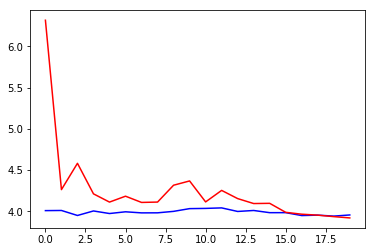

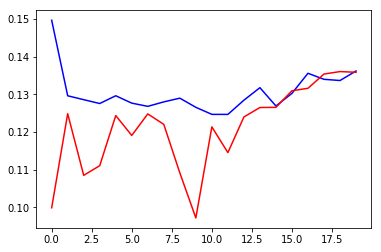

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [40]:
%%time
final_loss, final_acc = model.evaluate_generator(
    val_generator,
    max_queue_size=batch_size,
    workers=cpu_amount,
    use_multiprocessing=False,
    steps=1000,
    verbose=1
)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

1000/1000 [==============================] - 770s 770ms/step
Final loss: 3.9297, final accuracy: 0.1368
CPU times: user 1h 20min 51s, sys: 0 ns, total: 1h 20min 51s
Wall time: 12min 50s


In [41]:
run_name_acc = run_name + '_%04d' % (final_acc*10000)
print(run_name_acc)

inclusive-images-challenge_3_InceptionResNetV2_SE_20181024-143818_1368


In [42]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_folder, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'lr', 'val_acc', 'val_loss', 'epoch'], dtype='object')


In [43]:
weigthsFile = os.path.join(model_folder, run_name_acc + '.h5')
print(weigthsFile)
model.save(weigthsFile)

/data/kaggle-Inclusive-Images/model/inclusive-images-challenge_3_InceptionResNetV2_SE_20181024-143818_1368.h5


In [44]:
print('Time cost: %.2f' % (time.time() - time0))

print(run_name_acc)
print('Done !')

Time cost: 89752.01
inclusive-images-challenge_3_InceptionResNetV2_SE_20181024-143818_1368
Done !
